# Lab 3 - Query Expansion

In [1]:
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

In [ ]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

In [5]:
import os
import openai
import sys
sys.path.append('../..')
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv('.env\my_api_key.env')) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

path_chromadb_dump = '../Chromadb/'

In [6]:
from py3810.myUtils import pickle_dump, pickle_load

embeddings = pickle_load(filename_pickle='_embeddings', path_pickle_dump=path_chromadb_dump)
umap_transform = pickle_load(filename_pickle='_umap_transform', path_pickle_dump=path_chromadb_dump)
projected_dataset_embeddings = pickle_load(filename_pickle='_projected_dataset_embeddings', path_pickle_dump=path_chromadb_dump)

Don't run next cell if embeddings, umap_transform, projected_dataset_embeddings are loaded

In [ ]:
# import umap.umap_ as umap
# import numpy as np
# from tqdm import tqdm
# from py3810.myUtils import pickle_dump, pickle_load

# embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
# umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
# projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

# pickle_dump(file_to_pickle=embeddings, filename_pickle='_embeddings', path_pickle_dump=path_chromadb_dump)
# pickle_dump(file_to_pickle=umap_transform, filename_pickle='_umap_transform', path_pickle_dump=path_chromadb_dump)
# pickle_dump(file_to_pickle=projected_dataset_embeddings, filename_pickle='_projected_dataset_embeddings', path_pickle_dump=path_chromadb_dump)

## Expansion with generated answers

https://arxiv.org/abs/2305.03653

In [7]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. "
        },
        {"role": "user", "content": query}
    ] 

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [8]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

Was there significant turnover in the executive team? During the fiscal
year 20XX, there were no significant changes in the composition of the
executive team at our company. The leadership continuity has
contributed to the stability and strategic direction of the
organization.


In [9]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(word_wrap(doc))
    print('')

30 management ’ s discussion and analysis of financial condition and
results of operations the following management ’ s discussion and
analysis of financial condition and results of operations ( “ md & a ”
) is intended to help the reader understand the results of operations
and financial condition of microsoft corporation. md & a is provided as
a supplement to, and should be read in conjunction with, our
consolidated financial statements and the accompanying notes to
financial statements in our fiscal year 2022 form 10 - k. this section
generally discusses the results of our operations for the year ended
june 30, 2022 compared to the year ended june 30, 2021. for a
discussion of the year ended june 30, 2021 compared to the year ended
june 30, 2020, please refer to in our fiscal year 2022 form 10 - k, “
management ’ s discussion and analysis of financial condition and
results of operations ” in our annual report on form 10 - k for the
year ended june 30, 2021. overview

to be their aut

In [10]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


(-0.4267502035945654,
 10.904596148058772,
 5.316428327560425,
 11.376193857192993)

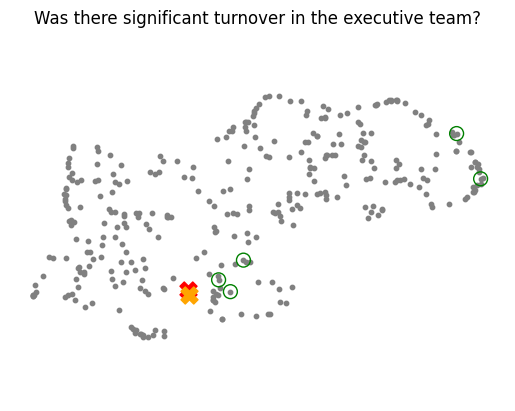

In [11]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

## Expansion with multiple queries


In [12]:
def augment_multiple_query(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [13]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

- What were the key revenue drivers for the company during the reporting period?
- How did changes in market conditions impact the company's revenue growth?
- Were there any new product launches or acquisitions that drove revenue growth?
- Did the company experience any pricing changes that affected its revenue?
- How did shifts in consumer behavior impact the company's revenue performance?


In [14]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
engineering, gaming, and linkedin. • sales and marketing expenses
increased $ 1. 7 billion or 8 % driven by investments in commercial
sales and linkedin. sales and marketing included a favorable foreign
currency impact of 2 %. • general and administrative expenses increased
$ 793 million or 16 % driven by investments in corporate functions.
operating income increased $ 13. 5 billion or 19 % driven by growth
across each of our segments. current year net income and diluted eps
were positively impacted by the net tax benefit related to the transfer
of intangible properties, which resulted in an increase to net income
and diluted eps of $ 3. 3 billion and $ 0. 44, respectively. prior year
net income and diluted eps were positively impacted by the net tax
benefit related to the india supreme court decision on withholding
taxes, which resulted in an increase to net income and diluted eps of $
620 

In [15]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|██████████| 5/5 [00:12<00:00,  2.44s/it]


In [16]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|██████████| 30/30 [01:13<00:00,  2.46s/it]


(-0.4267502035945654,
 10.904596148058772,
 5.316428327560425,
 11.376193857192993)

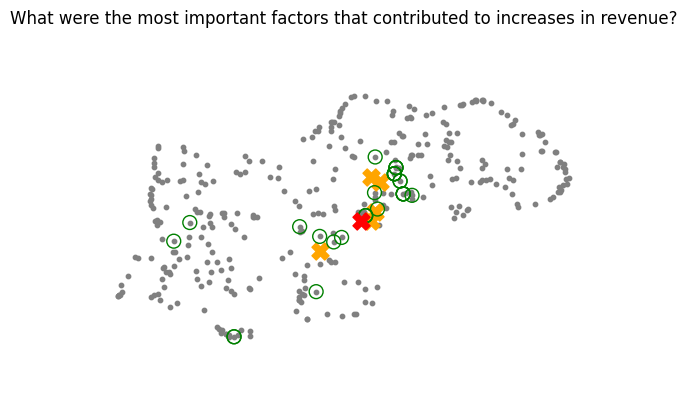

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')